In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST


In [21]:
train_data = FashionMNIST(
    root= "./data/FashionMNIST",
    train=True,
    transform=transforms.ToTensor(),
    download=False
)

In [22]:
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=False,
    num_workers=2,
)
print("train_loader的batch数量为：",len(train_loader))

train_loader的batch数量为： 938


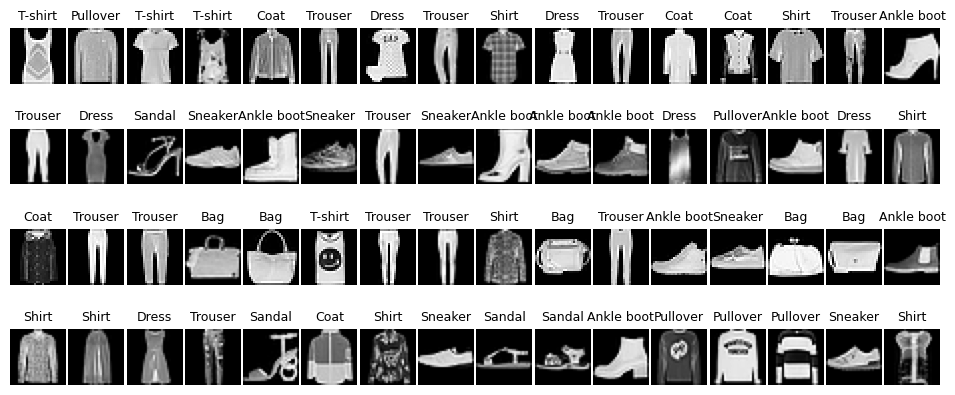

In [23]:
for step,(b_x,b_y) in enumerate(train_loader):
    if step > 0:
        break
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
class_label[0] = "T-shirt"
plt.figure(figsize=(12,5))
for ii in np.arange(len(batch_y)):
    plt.subplot(4,16,ii+1)
    plt.imshow(batch_x[ii,:,:],cmap=plt.cm.gray)
    plt.title(class_label[batch_y[ii]],size = 9)
    plt.axis("off")
    plt.subplots_adjust(wspace = 0.05)


In [24]:
test_data = FashionMNIST(
    root="./data/FashionMNIST",
    train=False,
    download=False
)
test_data_X = test_data.data.type(torch.FloatTensor)/255.0
test_data_X = torch.unsqueeze(test_data_X,dim=1)
test_data_y = test_data.targets
print("test_data_x.shape:",test_data_X.shape)
print("test_data_y.shape:",test_data_y.shape)


test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


In [25]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size = 2,
                stride=2,
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0),
            nn.ReLU(),
            nn.AvgPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1)
        output = self.classifier(x)
        return output
myconvnet = MyConvNet()
print(myconvnet)
    

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [29]:
def train_model(model,traindataloader,train_rate,criterion,optimizer,num_epochs=25):
   batch_num = len(traindataloader)
   train_batch_num = round(batch_num*train_rate)
   best_model_wts = copy.deepcopy(model.state_dict())
   best_acc = 0.0
   train_loss_all = []
   train_acc_all = []
   val_loss_all = []
   val_acc_all = []
   since = time.time()
   for epoch in range(num_epochs):
      print('Epoch{}/{}'.format(epoch,num_epochs - 1))
      print('-' * 10)
      train_loss = 0.0
      train_corrects = 0
      train_num = 0
      val_loss = 0
      val_corrects = 0
      val_num = 0
      for step,(b_x,b_y) in enumerate(traindataloader):
        if step < train_batch_num:
            model.train()
            output = model(b_x)
            pre_lab = torch.argmax(output,1)
            loss = criterion(output,b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * b_x.size(0)
            train_corrects += torch.sum(pre_lab == b_y.data)
            train_num += b_x.size(0)
        else:
            model.eval()
            output = model(b_x)
            pre_lab = torch.argmax(output,1)
            loss = criterion(output,b_y)
            val_loss += loss.item() * b_x.size(0)
            val_corrects += torch.sum(pre_lab == b_y.data)
            val_num += b_x.size(0)
      train_loss_all.append(train_loss / train_num)
      train_acc_all.append(train_corrects.double().item()/train_num)
      val_loss_all.append(val_loss / val_num)
      val_acc_all.append(val_corrects.double().item()/val_num)
      print('{}Train Loss:{:.4f}  Train Acc: {:.4f}'.format(epoch,train_loss_all[-1],train_acc_all[-1]))
      print('{}Val Loss:{:.4f}  Val Acc: {:.4f}'.format(epoch,val_loss_all[-1],val_acc_all[-1]))
      if val_acc_all[-1] > best_acc:
         best_acc = val_acc_all[-1]
         best_model_wts = copy.deepcopy(model.state_dict())
      time_use = time.time() - since
      print("Train and val complete in {:.0f}m {:.0f}s".format(time_use // 60,time_use % 60))
   model.load_state_dict(best_model_wts)
   train_process = pd.DataFrame(
      data={"epoch":range(num_epochs),
            "train_loss_all":train_loss_all,
            "val_loss_all":val_loss_all,
            "train_acc_all":train_acc_all,
            "val_acc_all":val_acc_all
            })
   return model,train_process


   
    
            

In [30]:
optimizer = torch.optim.Adam(myconvnet.parameters(),lr=0.0003)
criterion = nn.CrossEntropyLoss()
myconvnet,train_process = train_model(
    myconvnet,train_loader,0.8,criterion,optimizer,num_epochs=25)

Epoch0/24
----------
0Train Loss:0.4496  Train Acc: 0.8349
0Val Loss:0.4353  Val Acc: 0.8382
Train and val complete in 0m 16s
Epoch1/24
----------
1Train Loss:0.4062  Train Acc: 0.8515
1Val Loss:0.4081  Val Acc: 0.8504
Train and val complete in 0m 33s
Epoch2/24
----------
2Train Loss:0.3747  Train Acc: 0.8624
2Val Loss:0.3816  Val Acc: 0.8604
Train and val complete in 0m 50s
Epoch3/24
----------
3Train Loss:0.3504  Train Acc: 0.8708
3Val Loss:0.3588  Val Acc: 0.8687
Train and val complete in 1m 7s
Epoch4/24
----------
4Train Loss:0.3304  Train Acc: 0.8781
4Val Loss:0.3389  Val Acc: 0.8762
Train and val complete in 1m 23s
Epoch5/24
----------
5Train Loss:0.3144  Train Acc: 0.8842
5Val Loss:0.3267  Val Acc: 0.8808
Train and val complete in 1m 40s
Epoch6/24
----------
6Train Loss:0.3005  Train Acc: 0.8899
6Val Loss:0.3160  Val Acc: 0.8842
Train and val complete in 1m 57s
Epoch7/24
----------
7Train Loss:0.2882  Train Acc: 0.8939
7Val Loss:0.3069  Val Acc: 0.8874
Train and val complete in 

In [31]:
myconvnet.eval()
output = myconvnet(test_data_X)
pre_lab = torch.argmax(output,1)
acc = accuracy_score(test_data_y,pre_lab)
print("测试集精度:",acc)


测试集精度: 0.903
